## Analysis

## Importing Modules

In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

import seaborn as sns # visualizing univariate and bivariate data
import matplotlib.pyplot as plt # for making basic graphs

from num2words import num2words #converts number to words

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.linear_model import LinearRegression # Forecasting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

In [8]:
df = pd.read_csv(r"DataCoSupplyChainDataset.csv", encoding="latin1")
# By default, pd.read_csv assumes the file is UTF-8
# This file is in a different encoding - Latin-1

In [9]:
df.head(3)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

## Data Pre-Processing

In [11]:
df = df.drop(columns=['Customer Email', 'Customer Password', 'Customer Street', 'Product Description', 'Product Image', 'Product Status'])

In [12]:
df = df.drop_duplicates()

In [13]:
df.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Name,Product Price,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,Smart watch,327.75,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,South Asia,Rajastán,PENDING,NaN,1360,73,Smart watch,327.75,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,South Asia,Rajastán,CLOSED,NaN,1360,73,Smart watch,327.75,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,Oceania,Queensland,COMPLETE,NaN,1360,73,Smart watch,327.75,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,Smart watch,327.75,1/15/2018 11:24,Standard Class


In [14]:
np.sum(df.isna())

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Segment                      0
Customer State                        0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0
Order City                            0
Order Country                         0
Order Customer Id                     0


In [15]:
# For missing zip codes implemented cross-filling between customer and order zip codes.

# If 'Customer Zipcode' is missing (NaN), use 'Order Zipcode' if it has a value; else use 0.
df['Customer Zipcode'] = df.apply(
    lambda row: row['Order Zipcode'] if pd.isna(row['Customer Zipcode']) and pd.notna(row['Order Zipcode'])
    else (0 if pd.isna(row['Customer Zipcode']) else row['Customer Zipcode']),
    axis=1
)

# If 'Order Zipcode' is missing, use 'Customer Zipcode' if it has a value; else use 0.
df['Order Zipcode'] = df.apply(
    lambda row: row['Customer Zipcode'] if pd.isna(row['Order Zipcode']) and pd.notna(row['Customer Zipcode'])
    else (0 if pd.isna(row['Order Zipcode']) else row['Order Zipcode']),
    axis=1
)

# Combining the First & Last Name
df['Customer Name'] = df['Customer Fname'].fillna('') + ' ' + df['Customer Lname'].fillna('')
df['Customer Name'] = df['Customer Name'].str.strip()
df = df.drop(columns=['Customer Fname', 'Customer Lname'])

In [16]:
# order and shipping dates format made consistent
df['order_dt'] = pd.to_datetime(df['order date (DateOrders)'], errors='coerce')
df['ship_dt'] = pd.to_datetime(df['shipping date (DateOrders)'], errors='coerce')

# No. of Shipping delay days is the difference between the actual and the scheduled
df['shipping_delay'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']

In [17]:
# Finding out the NULL values
np.sum(df.isna())

Type                             0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Benefit per order                0
Sales per customer               0
Delivery Status                  0
Late_delivery_risk               0
Category Id                      0
Category Name                    0
Customer City                    0
Customer Country                 0
Customer Id                      0
Customer Segment                 0
Customer State                   0
Customer Zipcode                 0
Department Id                    0
Department Name                  0
Latitude                         0
Longitude                        0
Market                           0
Order City                       0
Order Country                    0
Order Customer Id                0
order date (DateOrders)          0
Order Id                         0
Order Item Cardprod Id           0
Order Item Discount              0
Order Item Discount Rate         0
Order Item Id       

In [18]:
# Statistical Summary of the dataset
round(df.describe(), 2)

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Price,order_dt,ship_dt,shipping_delay
count,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,...,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519,180519,180519.00
mean,3.50,2.93,21.97,183.11,0.55,31.85,6691.38,35920.53,5.44,29.72,...,203.77,183.11,21.97,38530.17,692.51,31.85,141.23,2016-06-12 17:47:04.669868544,2016-06-16 05:45:23.202433024,0.57
min,0.00,0.00,-4274.98,7.49,0.00,2.00,1.00,0.00,2.00,-33.94,...,9.99,7.49,-4274.98,0.00,19.00,2.00,9.99,2015-01-01 00:00:00,2015-01-03 00:00:00,-2.00
25%,2.00,2.00,7.00,104.38,0.00,18.00,3258.50,725.00,4.00,18.27,...,119.98,104.38,7.00,725.00,403.00,18.00,50.00,2015-09-21 13:49:00,2015-09-25 06:59:00,0.00
50%,3.00,4.00,31.52,163.99,1.00,29.00,6457.00,19380.00,5.00,33.14,...,199.92,163.99,31.52,27606.00,627.00,29.00,59.99,2016-06-11 13:06:00,2016-06-15 08:32:00,1.00
75%,5.00,4.00,64.80,247.40,1.00,45.00,9779.00,78207.00,7.00,39.28,...,299.95,247.40,64.80,78745.00,1004.00,45.00,199.99,2017-03-01 08:42:00,2017-03-04 21:29:00,1.00
max,6.00,4.00,911.80,1939.99,1.00,76.00,20757.00,99205.00,12.00,48.78,...,1999.99,1939.99,911.80,99301.00,1363.00,76.00,1999.99,2018-01-31 23:38:00,2018-02-06 22:14:00,4.00
std,1.62,1.37,104.43,120.04,0.50,15.64,4162.92,37542.43,1.63,9.81,...,132.27,120.04,104.43,37423.32,336.45,15.64,139.73,NaN,NaN,1.49


## Exploratory Data Visualization

In [19]:
def bar_chart(category, title, top_n=None, rotation=0):
    value_counts = df[category].value_counts()
    if top_n:
        value_counts = value_counts[:top_n]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.values, y=value_counts.index, palette="crest")
    plt.title(title, fontsize=18)
    plt.xlabel("Count")
    plt.ylabel(category)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()


def quant_count(num_var, title, bins=30, color="steelblue"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    sns.histplot(df[num_var], bins=bins, kde=True, color=color)
    plt.title(title, fontsize=18)
    plt.xlabel(num_var)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

**Logistics & Operations**

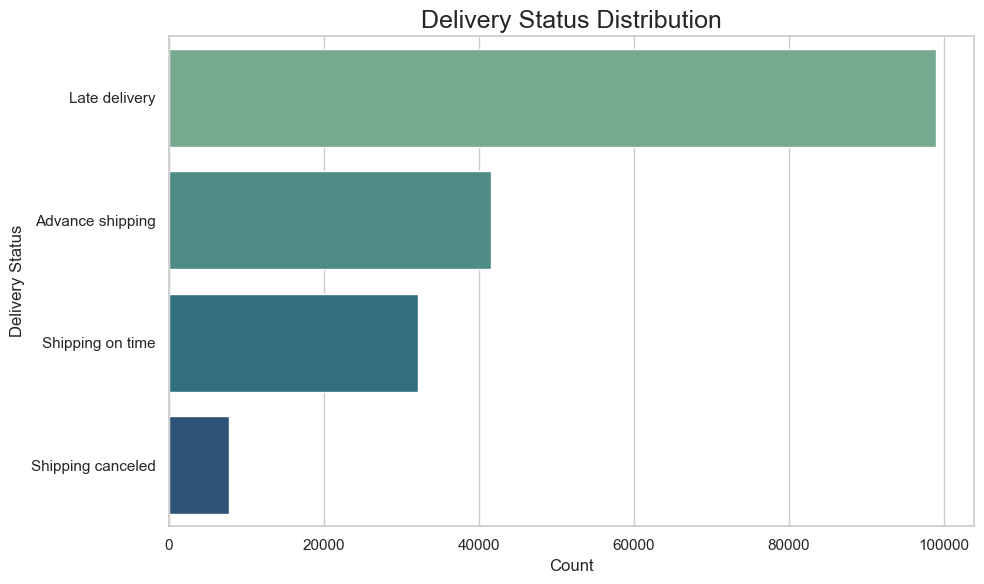

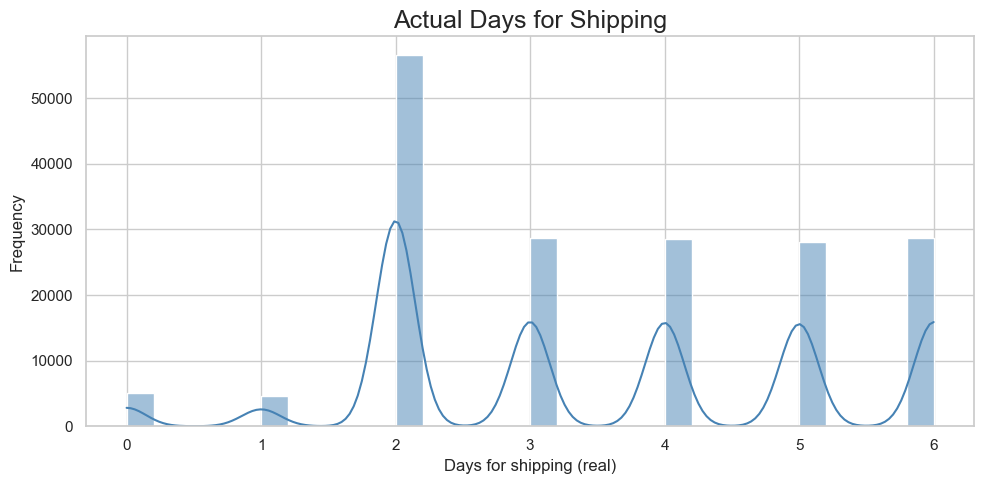

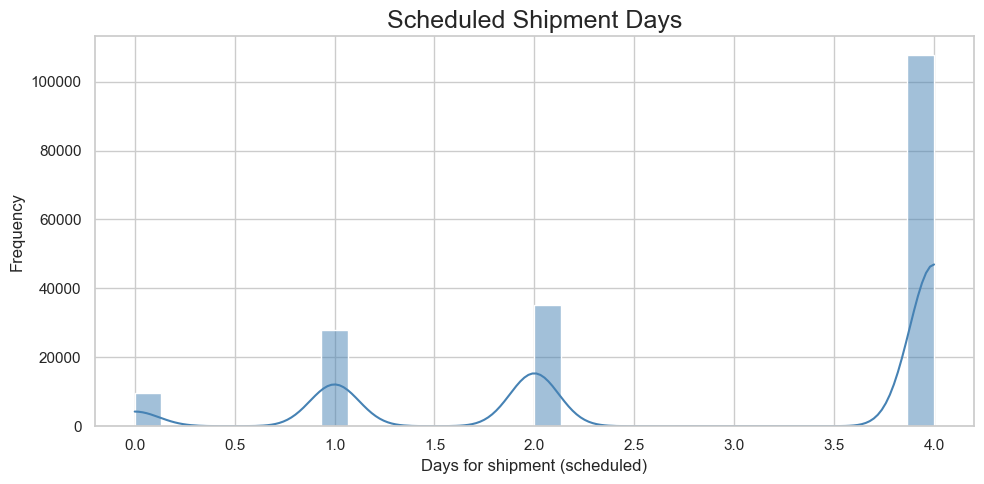

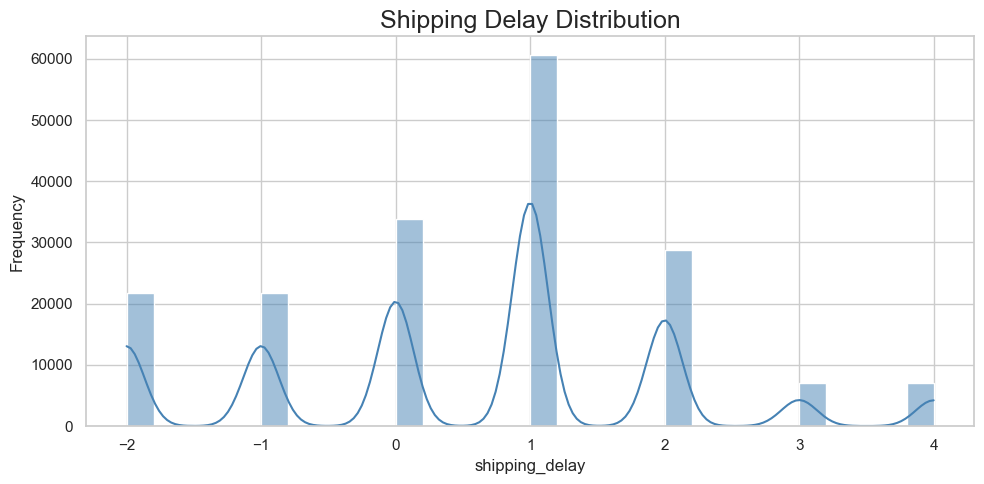

In [21]:
bar_chart("Delivery Status", "Delivery Status Distribution")
quant_count("Days for shipping (real)", "Actual Days for Shipping")
quant_count("Days for shipment (scheduled)", "Scheduled Shipment Days")
quant_count("shipping_delay", "Shipping Delay Distribution")

**Sales & Profit**

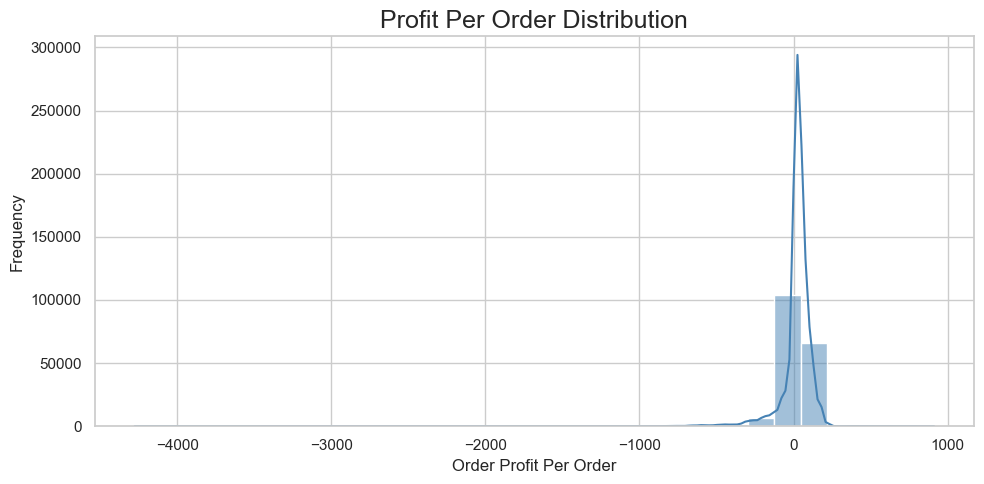

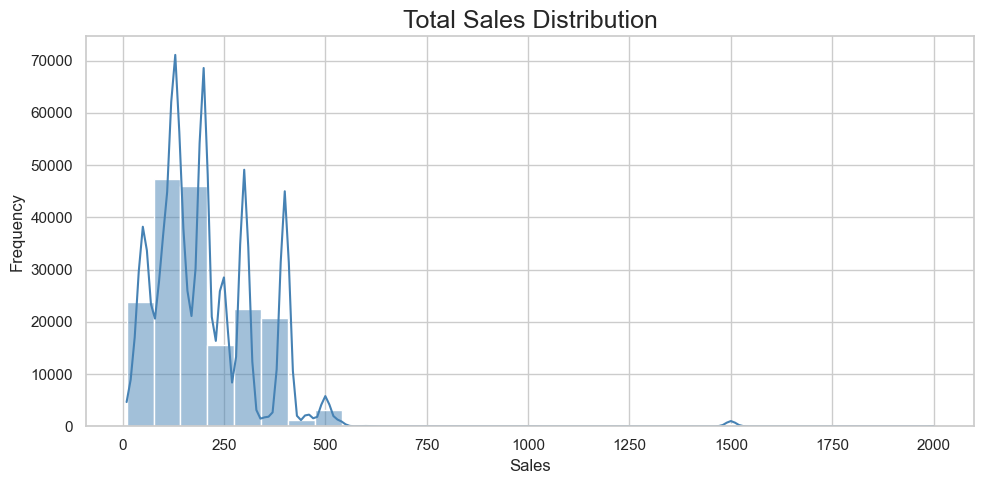

In [23]:
quant_count("Order Profit Per Order", "Profit Per Order Distribution")
quant_count("Sales", "Total Sales Distribution")

**Customer Insights**

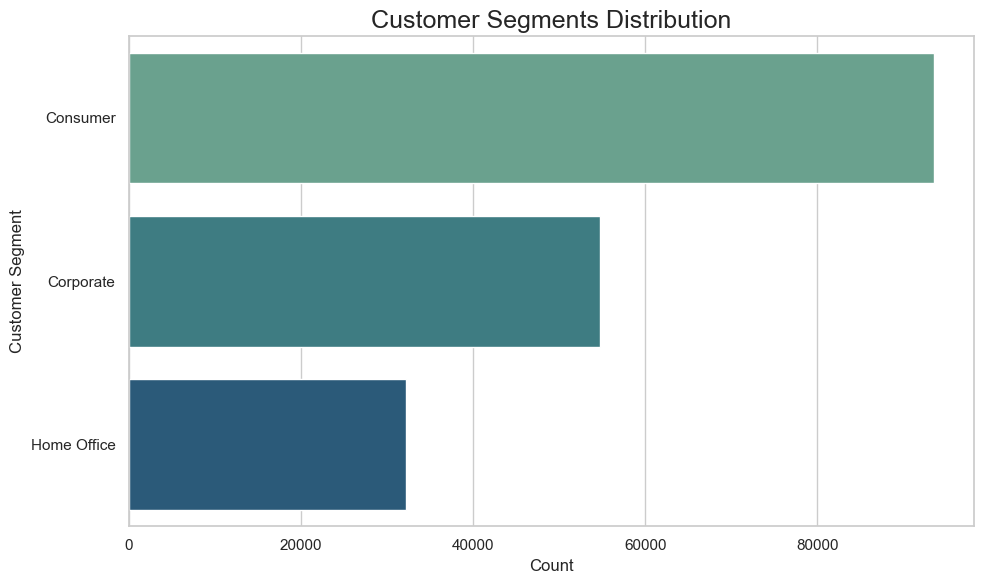

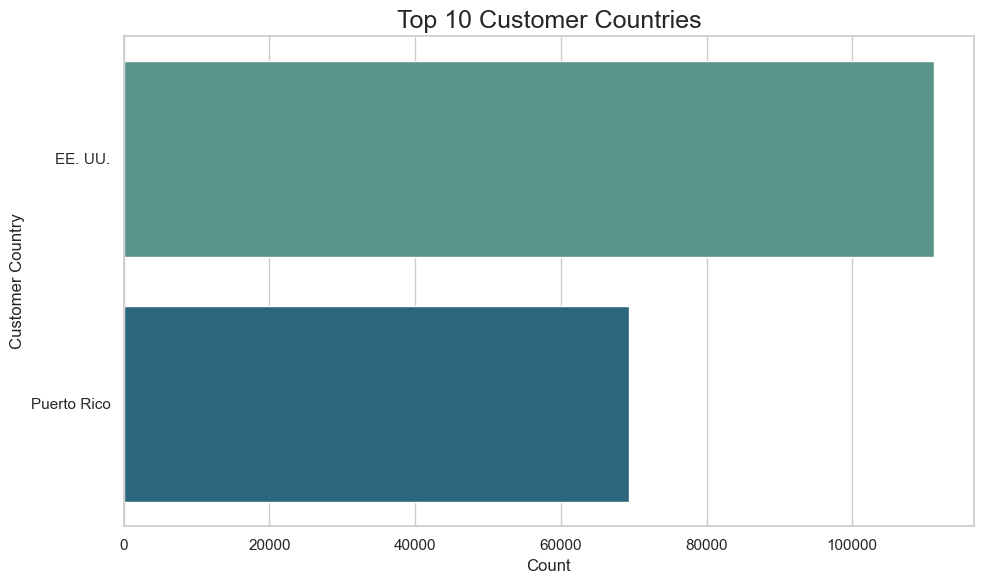

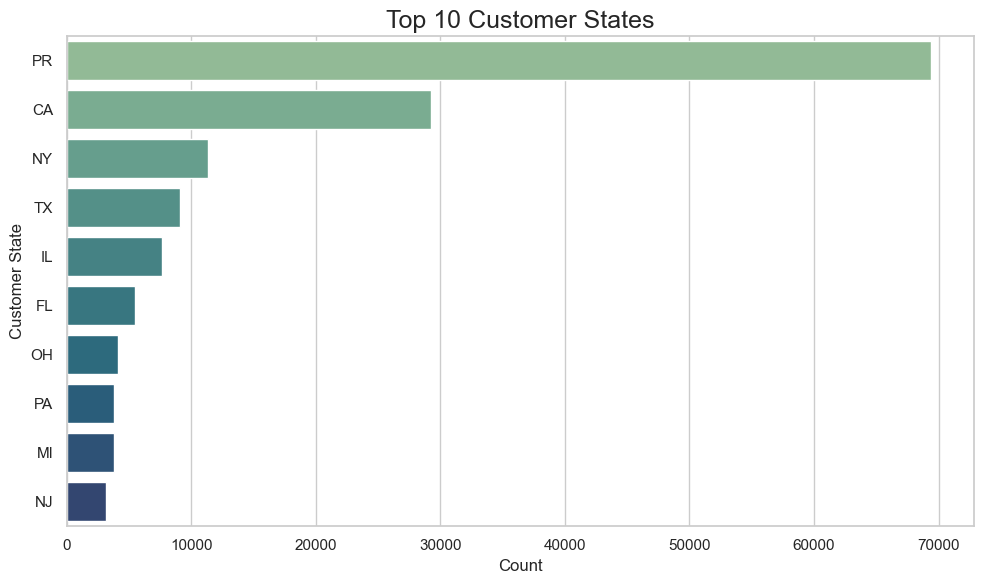

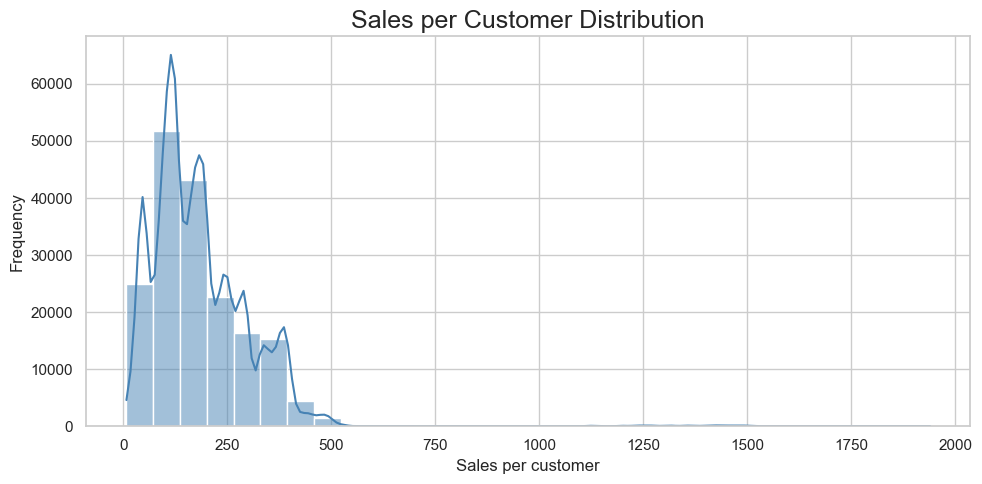

In [24]:
bar_chart("Customer Segment", "Customer Segments Distribution")
bar_chart("Customer Country", "Top 10 Customer Countries", top_n=10)
bar_chart("Customer State", "Top 10 Customer States", top_n=10)
quant_count("Sales per customer", "Sales per Customer Distribution")

**Product Analytics**

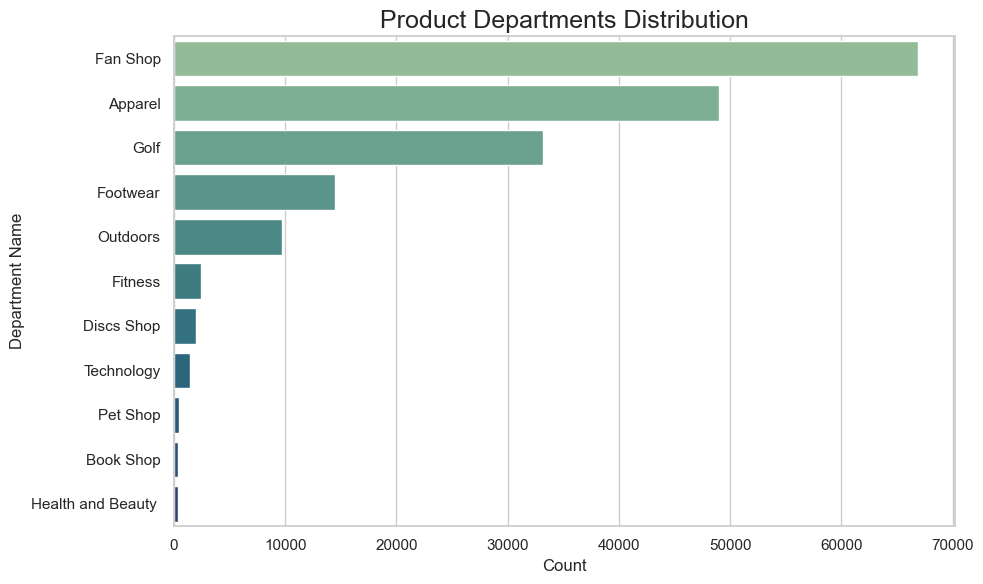

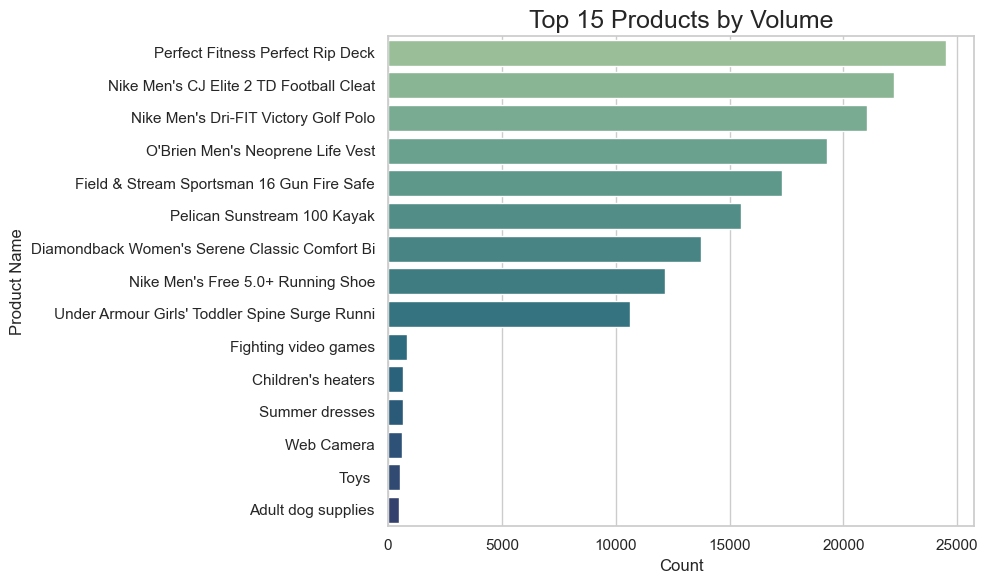

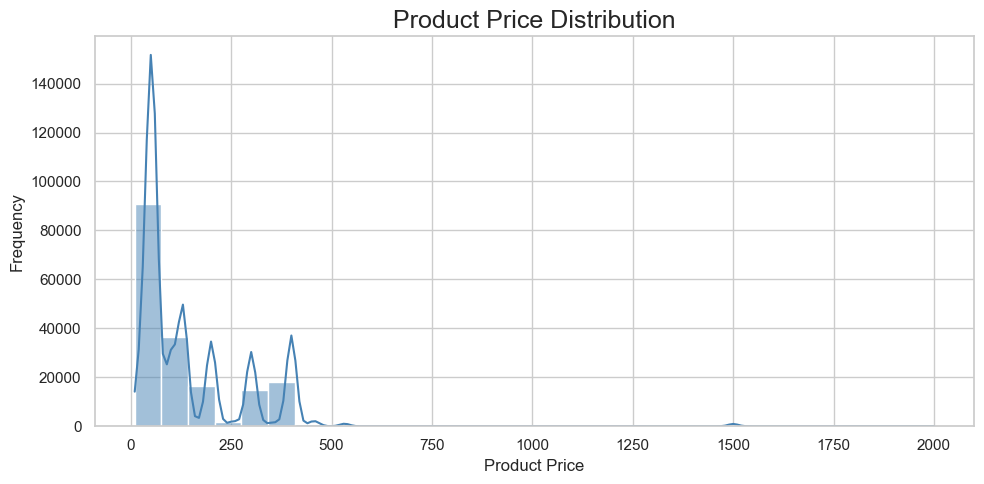

In [25]:
bar_chart("Department Name", "Product Departments Distribution")
bar_chart("Product Name", "Top 15 Products by Volume", top_n=15)
quant_count("Product Price", "Product Price Distribution")

**Geographic Distribution**

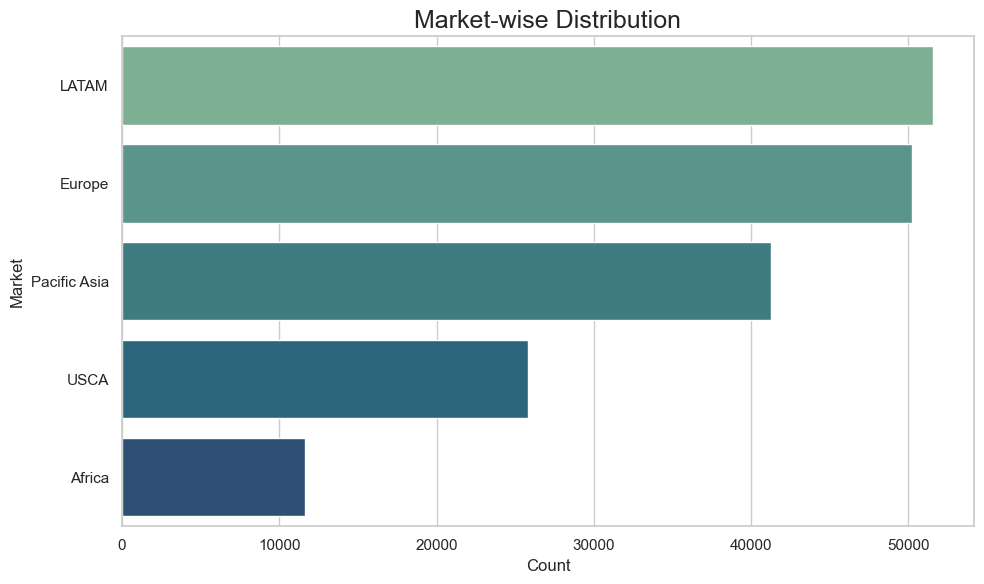

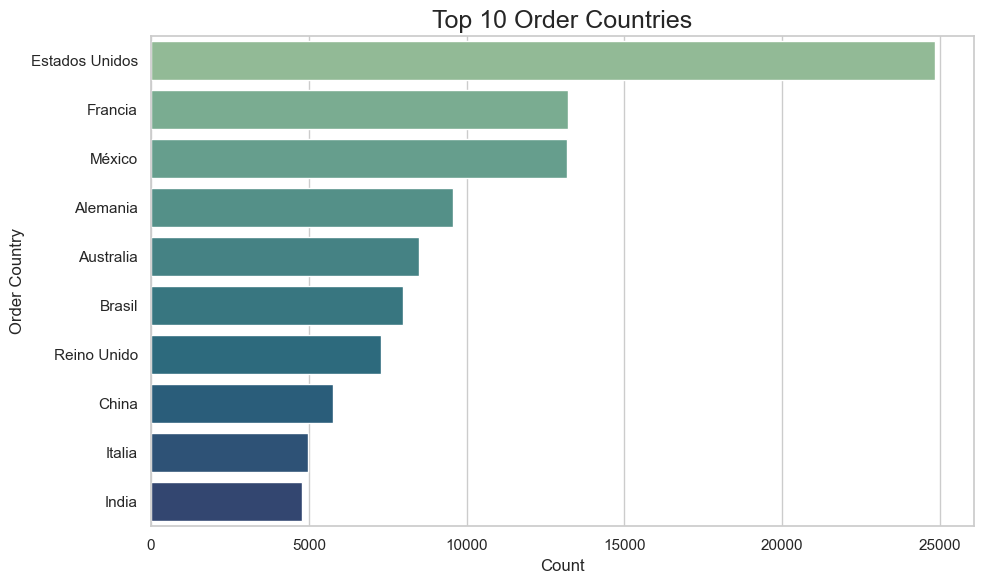

In [26]:
bar_chart("Market", "Market-wise Distribution")
bar_chart("Order Country", "Top 10 Order Countries", top_n=10)

**Order & Shipping Mode**

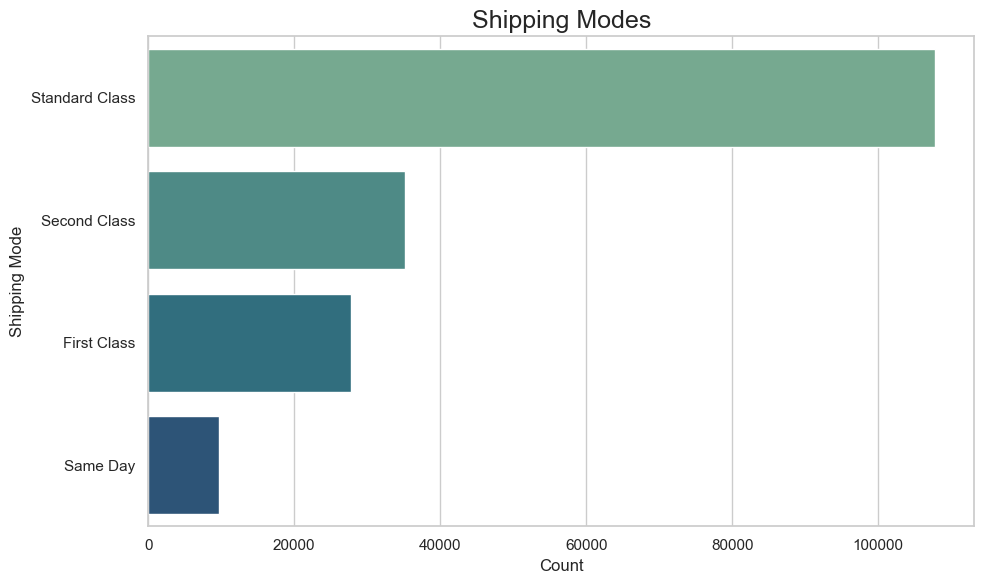

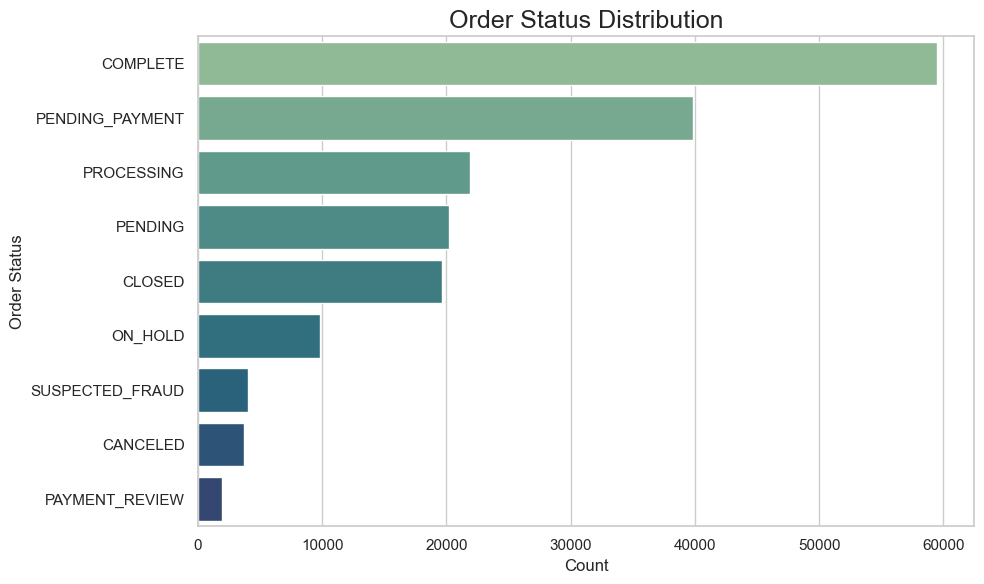

In [27]:
bar_chart("Shipping Mode", "Shipping Modes")
bar_chart("Order Status", "Order Status Distribution")

## KPI Computation & Business Insights

In [28]:
# organised order status categories into 4 major boxes - completed, pending, fraud, cancelled 
completed_statuses = {'COMPLETE','CLOSED','PROCESSING','PAYMENT_RECEIVED','FINISHED'}
cancel_statuses    = {'CANCELED'}
fraud_statuses     = {'SUSPECTED_FRAUD'}
pending_statuses   = {'PENDING','PENDING_PAYMENT','ON_HOLD','PAYMENT_REVIEW'}
payment_on_hold    = {'PENDING_PAYMENT','PAYMENT_REVIEW'} 

In [29]:
# Group by order to remove item-level duplication
all_orders_grouped = df.groupby('Order Id').first()

# Total number of orders (completed or not)
total_orders = all_orders_grouped.shape[0]
print(f"Total number of orders: {total_orders}")

# Total unique customers among all orders
all_unique_customers = all_orders_grouped['Customer Id'].nunique()
print(f"Total number of unique customers: {all_unique_customers}")

Total number of orders: 65752
Total number of unique customers: 20652


**NOTE:**
The dataset is at order item level → each order can have multiple items, so appears in multiple rows.
We can infer this as we got
- Total no. of orders: 20,652
- Total no. of completed orders: 20,652
- Total no. of unique customers: 20,652
- Number of repeat customers: 12,217

If we have 20,652 total orders and also 20,652 unique customers,
- then each customer placed exactly one order.
- So number of repeat customers should be zero and not 12,217.

In [30]:
# Filter completed orders "completed_statuses"
completed_orders = df[df['Order Status'].isin(completed_statuses)]

# Group by order to remove item-level duplication
completed_orders_grouped = completed_orders.groupby('Order Id').first()

# Total number of completed orders
total_completed_orders = completed_orders_grouped.shape[0]
print(f"Total number of completed orders: {total_completed_orders}")

# Total unique customers among these completed orders
total_unique_customers_completed_orders = completed_orders_grouped['Customer Id'].nunique()
print(f"Total number of unique customers: {total_unique_customers_completed_orders}")

# Number of repeat customers (customers who placed >1 completed order)
customer_order_counts = completed_orders_grouped['Customer Id'].value_counts()
repeat_customers = (customer_order_counts > 1).sum()
print(f"Number of repeat customers: {repeat_customers}")

# Number of repeat customers (customers who placed >2 completed order)
customer_order_counts_over_2 = completed_orders_grouped['Customer Id'].value_counts()
repeat_customers_over_2 = (customer_order_counts_over_2 > 2).sum()
print(f"Number of repeat customers: {repeat_customers_over_2}")

# Number of regular customers (customers who placed >5 completed order)
customer_order_counts = completed_orders_grouped['Customer Id'].value_counts()
regular_customers = (customer_order_counts > 5).sum()
print(f"Number of regular customers: {regular_customers}")

# Repeat purchase rate
repeat_purchase_rate = repeat_customers / total_unique_customers_completed_orders
print(f"Repeat purchase rate: {repeat_purchase_rate:.2%}")

# Average sales per customer
average_sales_per_customer = total_completed_orders / total_unique_customers_completed_orders
print(f"Average sales per customer: {average_sales_per_customer:.3}")

# Average quantity per order
average_quantity_per_order = completed_orders.shape[0] / total_completed_orders
print(f"Average quantity per order: {average_quantity_per_order:.3}")

# Rate of paid customers
rate_of_paid_customers = total_unique_customers_completed_orders / all_unique_customers
print(f"Rate of paid customers: {rate_of_paid_customers: .3%}")

Total number of completed orders: 36866
Total number of unique customers: 16206
Number of repeat customers: 9092
Number of repeat customers: 6007
Number of regular customers: 570
Repeat purchase rate: 56.10%
Average sales per customer: 2.27
Average quantity per order: 2.74
Rate of paid customers:  78.472%


In [31]:
# Find earliest and latest order dates of the datset
print("Earliest order date:", completed_orders['order_dt'].min())
print("Latest order date:", completed_orders['order_dt'].max())

Earliest order date: 2015-01-01 00:00:00
Latest order date: 2018-01-31 23:38:00


**Financial KPIs**

In [37]:
# Total Revenue
total_revenue = completed_orders['Order Item Total'].sum()
print(f"Total Revenue: ${total_revenue: .3f} ({num2words(total_revenue, to = 'currency')})")

# Total Profit
total_profit = completed_orders['Order Profit Per Order'].sum()
print(f"Total Profit: ${total_profit: .3f} ({num2words(total_profit, to = 'currency')})")

# Profit margin overall
profit_margin_overall = total_profit / total_revenue
print(f"Profit margin overall: {profit_margin_overall: .3%}")

# Average order value (AOV)
average_revenue_per_order = total_revenue / total_completed_orders
print(f"Average order value (AOV): ${average_revenue_per_order: .3f} ({num2words(average_revenue_per_order, to = 'currency')})")

# Average revenue per customer who completed order
average_revenue_per_customer = total_revenue / total_unique_customers_completed_orders
print(f"Average revenue per customer who completed order: ${average_revenue_per_customer: .3f} ({num2words(average_revenue_per_customer, to = 'currency')})")

Total Revenue: $ 18528119.350 (eighteen million, five hundred and twenty-eight thousand, one hundred and nineteen euro, thirty-five cents)
Total Profit: $ 2274542.713 (two million, two hundred and seventy-four thousand, five hundred and forty-two euro, seventy-one cents)
Profit margin overall:  12.276%
Average order value (AOV): $ 502.580 (five hundred and two euro, fifty-eight cents)
Average revenue per customer who completed order: $ 1143.288 (one thousand, one hundred and forty-three euro, twenty-nine cents)


**Customer Insights KPIs**

In [39]:
# Step 1: Prepare customer-level order history
completed_orders['order_dt'] = pd.to_datetime(completed_orders['order_dt'], errors='coerce')
ref_date = completed_orders['order_dt'].max()

# Step 2: Get last purchase date per customer
cust_last_purchase = completed_orders.groupby('Customer Id')['order_dt'].max().reset_index()
cust_last_purchase['days_since_last_purchase'] = (ref_date - cust_last_purchase['order_dt']).dt.days

# Step 3: Churn flag (assuming 180-day churn threshold)
churn_threshold = 240
cust_last_purchase['is_churned'] = (cust_last_purchase['days_since_last_purchase'] > churn_threshold).astype(int)

# Step 4: Churn Rate
total_customers = cust_last_purchase.shape[0]
churned_customers = cust_last_purchase['is_churned'].sum()
churn_rate = churned_customers / total_customers

print(f"Churn Rate (240-day window): {churn_rate:.2%}")

Churn Rate (240-day window): 50.94%


C:\Users\conta\AppData\Local\Temp\ipykernel_17364\923071091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_orders['order_dt'] = pd.to_datetime(completed_orders['order_dt'], errors='coerce')


In [40]:
cust_life = completed_orders.groupby('Customer Id').agg(
    first_purchase=('order_dt','min'),
    last_purchase=('order_dt','max')
).reset_index()

cust_life['lifespan_days'] = (cust_life['last_purchase'] - cust_life['first_purchase']).dt.days
avg_lifespan_days = cust_life['lifespan_days'].mean()
print(f"Average Customer Lifespan: {avg_lifespan_days:.3f} days (~{avg_lifespan_days/30:.1f} months)")

life_time_value = average_revenue_per_customer * average_sales_per_customer * avg_lifespan_days / 365
print(f"Customer Lifetime Value (LTV): ${life_time_value: .3f} ({num2words(life_time_value, to = 'currency')})")

Average Customer Lifespan: 279.657 days (~9.3 months)
Customer Lifetime Value (LTV): $ 1992.681 (one thousand, nine hundred and ninety-two euro, sixty-eight cents)


In [41]:
# Number of cancelled orders
cancelled_orders = df[df['Order Status'].isin(cancel_statuses)]
cancelled_orders_grouped = cancelled_orders.groupby('Order Id').first()
total_cancelled_orders = cancelled_orders_grouped.shape[0]
print(f"Number of cancelled orders: {total_cancelled_orders}")

print("-"*40)

# Cancellation rate
cancellation_rate = total_cancelled_orders / total_orders
print(f"Cancellation rate: {cancellation_rate: .3%}")

print("-" * 40)

# Number of On hold orders
pending_orders = df[df['Order Status'].isin(pending_statuses)]
pending_orders_grouped = pending_orders.groupby('Order Id').first()
total_pending_orders = pending_orders_grouped.shape[0]
print(f"Number of pending orders: {total_pending_orders}")

print("-" * 40)

# On hold rate
pending_orders_rate = total_pending_orders / total_orders
print(f"Pending Orders Rate: {pending_orders_rate: .3%}")

print("-" * 40)

# Number of Suspected fraud orders
fraud_orders = df[df['Order Status'].isin(fraud_statuses)]
fraud_orders_grouped = fraud_orders.groupby('Order Id').first()
total_fraud_orders = fraud_orders_grouped.shape[0]
print(f"Number of suspected fraud orders: {total_fraud_orders}")

print("-" * 40)

# Suspected fraud rate
fraud_rate = total_fraud_orders / total_orders
print(f"Suspected fraud rate: {fraud_rate: .3%}")

Number of cancelled orders: 1367
----------------------------------------
Cancellation rate:  2.079%
----------------------------------------
Number of pending orders: 26031
----------------------------------------
Pending Orders Rate:  39.590%
----------------------------------------
Number of suspected fraud orders: 1488
----------------------------------------
Suspected fraud rate:  2.263%


In [42]:
# Total sales and profit per customer
customer_sales = (
    completed_orders_grouped.groupby("Customer Id")["Order Item Total"]
    .sum()
    .sort_values(ascending=False)
)
customer_profit = (
    completed_orders_grouped.groupby("Customer Id")["Order Profit Per Order"]
    .sum()
    .sort_values(ascending=False)
)

# Top 10 customers
top_10_customers_sales = customer_sales.head(10)
top_10_customers_profit = customer_profit.head(10)

# Print formatted tables
print("Top 10 Customers by Sales:")
print("=" * 29)
print("| Customer ID | Total Sales |")
print("|" + "-" * 27 + "|")
for customer_id, sales in top_10_customers_sales.items():
    print(f"| {customer_id:<11} | ${sales:>10.2f} |")
print("=" * 29)

print("\nTop 10 Customers by Profit:")
print("=" * 30)
print("| Customer ID | Total Profit |")
print("|" + "-" * 28 + "|")
for customer_id, profit in top_10_customers_profit.items():
    print(f"| {customer_id:<11} | ${profit:>11.2f} |")
print("=" * 30)

Top 10 Customers by Sales:
| Customer ID | Total Sales |
|---------------------------|
| 5533        | $   2738.69 |
| 5283        | $   2429.56 |
| 8462        | $   2278.67 |
| 1223        | $   2240.24 |
| 2564        | $   2133.25 |
| 1428        | $   1974.37 |
| 1833        | $   1949.95 |
| 9300        | $   1943.59 |
| 4596        | $   1829.90 |
| 11061       | $   1808.22 |

Top 10 Customers by Profit:
| Customer ID | Total Profit |
|----------------------------|
| 2564        | $     951.61 |
| 5533        | $     802.27 |
| 14111       | $     720.30 |
| 14254       | $     712.95 |
| 14089       | $     708.75 |
| 14255       | $     705.60 |
| 14237       | $     705.60 |
| 14095       | $     705.00 |
| 14346       | $     697.95 |
| 18117       | $     690.90 |


In [43]:
# Top 5% customers
top_5_percent_count = int(total_unique_customers_completed_orders * 0.05)
top_5_percent_customers_sales = customer_sales.head(top_5_percent_count)
average_sales_top_5_percent = top_5_percent_customers_sales.mean()

# Top 10% customers
top_10_percent_count = int(total_unique_customers_completed_orders * 0.10)
top_10_percent_customers_sales = customer_sales.head(top_10_percent_count)
average_sales_top_10_percent = top_10_percent_customers_sales.mean()

# Next 20% customers
top_10_to_30_percent_count = int(total_unique_customers_completed_orders * 0.20)
top_10_to_30_percent_customers_sales = customer_sales.iloc[top_10_percent_count: top_10_percent_count + top_10_to_30_percent_count]
average_sales_top_10_to_30_percent = top_10_to_30_percent_customers_sales.mean()

# Next 30% customers
next_30_percent_count = int(total_unique_customers_completed_orders * 0.30)
next_30_percent_customers_sales = customer_sales.iloc[top_10_percent_count+top_10_to_30_percent_count:top_10_percent_count+top_10_to_30_percent_count+next_30_percent_count]
average_sales_next_30_percent = next_30_percent_customers_sales.mean()

# Bottom 40% customers
bottom_40_percent_count = int(total_unique_customers_completed_orders * 0.40)
bottom_40_percent_customers_sales = customer_sales.tail(bottom_40_percent_count)
average_sales_bottom_40_percent = bottom_40_percent_customers_sales.mean()

# Print customer segmentation analysis
print(f"\nCustomer Segmentation Analysis:")
print("=" * 30)
print(f"Total Customers: {total_unique_customers_completed_orders}")
print(f"Top 5% Customers ({top_5_percent_count} customers):")
print(f"  - Average Sales: ${average_sales_top_5_percent:.2f}")
print(f"  - Total Sales: ${top_5_percent_customers_sales.sum():.2f}")
print(f"  - Percentage of Total Sales: {(top_5_percent_customers_sales.sum() / customer_sales.sum() * 100):.1f}%")

print(f"\nTop 10% Customers ({top_10_percent_count} customers):")
print(f"  - Average Sales: ${average_sales_top_10_percent:.2f}")
print(f"  - Total Sales: ${top_10_percent_customers_sales.sum():.2f}")
print(f"  - Percentage of Total Sales: {(top_10_percent_customers_sales.sum() / customer_sales.sum() * 100):.1f}%")

print(f"\nNext 20% Customers ({top_10_to_30_percent_count} customers):")
print(f"  - Average Sales: ${average_sales_top_10_to_30_percent:.2f}")
print(f"  - Total Sales: ${top_10_to_30_percent_customers_sales.sum():.2f}")
print(f"  - Percentage of Total Sales: {(top_10_to_30_percent_customers_sales.sum() / customer_sales.sum() * 100):.1f}%")

print(f"\nNext 30% Customers ({next_30_percent_count} customers):")
print(f"  - Average Sales: ${average_sales_next_30_percent:.2f}")
print(f"  - Total Sales: ${next_30_percent_customers_sales.sum():.2f}")
print(f"  - Percentage of Total Sales: {(next_30_percent_customers_sales.sum() / customer_sales.sum() * 100):.1f}%")

print(f"\nBottom 40% Customers ({bottom_40_percent_count} customers):")
print(f"  - Average Sales: ${average_sales_bottom_40_percent:.2f}")
print(f"  - Total Sales: ${bottom_40_percent_customers_sales.sum():.2f}")
print(f"  - Percentage of Total Sales: {(bottom_40_percent_customers_sales.sum() / customer_sales.sum() * 100):.1f}%")


Customer Segmentation Analysis:
Total Customers: 16206
Top 5% Customers (810 customers):
  - Average Sales: $1252.16
  - Total Sales: $1014249.98
  - Percentage of Total Sales: 15.6%

Top 10% Customers (1620 customers):
  - Average Sales: $1073.67
  - Total Sales: $1739340.99
  - Percentage of Total Sales: 26.8%

Next 20% Customers (3241 customers):
  - Average Sales: $620.92
  - Total Sales: $2012408.84
  - Percentage of Total Sales: 31.0%

Next 30% Customers (4861 customers):
  - Average Sales: $374.65
  - Total Sales: $1821183.10
  - Percentage of Total Sales: 28.1%

Bottom 40% Customers (6482 customers):
  - Average Sales: $140.35
  - Total Sales: $909726.60
  - Percentage of Total Sales: 14.0%


In [44]:
first_time_buyers = (customer_order_counts == 1).sum()
first_time_buyer_rate = first_time_buyers / total_unique_customers_completed_orders
print(f"First-Time Buyer Rate: {first_time_buyer_rate:.2%}")

First-Time Buyer Rate: 43.90%


In [45]:
customer_order_dates = completed_orders.groupby('Customer Id')['order_dt'].apply(list)
avg_gap_days = customer_order_dates.apply(lambda dates: 
    np.mean(np.diff(sorted(dates))).days if len(dates) > 1 else np.nan)

print(f"Average Time Between Orders (repeat customers): {avg_gap_days.mean():.1f} days")

Average Time Between Orders (repeat customers): 58.4 days


In [46]:
discounted_orders = completed_orders[completed_orders['Order Item Discount'] > 0]['Order Id'].nunique()
discount_penetration_rate = discounted_orders / total_completed_orders
print(f"Discount Penetration Rate: {discount_penetration_rate:.2%}")

avg_discount_given = completed_orders['Order Item Discount'].mean()
print(f"Average Discount per Order Item: ${avg_discount_given:.2f}")

Discount Penetration Rate: 98.26%
Average Discount per Order Item: $20.73


In [47]:
late_deliveries = completed_orders[completed_orders['Late_delivery_risk'] == 1]['Order Id'].nunique()
late_delivery_rate = late_deliveries / total_completed_orders
print(f"Late Delivery Rate: {late_delivery_rate:.2%}")

completed_orders['shipping_delay'] = completed_orders['Days for shipping (real)'] - completed_orders['Days for shipment (scheduled)']
avg_shipping_delay = completed_orders['shipping_delay'].mean()
print(f"Average Shipping Delay: {avg_shipping_delay:.2f} days")

Late Delivery Rate: 57.31%
Average Shipping Delay: 0.56 days


C:\Users\conta\AppData\Local\Temp\ipykernel_17364\1903190850.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_orders['shipping_delay'] = completed_orders['Days for shipping (real)'] - completed_orders['Days for shipment (scheduled)']


In [48]:
# Revenue by Category
revenue_by_category = completed_orders.groupby('Category Name')['Order Item Total'].sum().sort_values(ascending=False)
print("|       Category       |    Revenue   | Contribution (%) |")
print("|" + "-" * 50 + "|")
for category, revenue in revenue_by_category.items():
    contribution = (revenue / total_revenue) * 100
    print(f"| {category:<20} | ${revenue:>11.2f} | {contribution:>15.2f}% |")
print("=" * 52)

# Profit Margin by Category
category_margin = completed_orders.groupby('Category Name').agg(
    total_sales=('Order Item Total', 'sum'),
    total_profit=('Order Profit Per Order', 'sum')
)
category_margin['profit_margin'] = category_margin['total_profit'] / category_margin['total_sales']

print("\n\n| Category Name         | Total Sales | Total Profit | Profit Margin |")
print("|" + "-" * 68 + "|")
for category, row in category_margin.sort_values('profit_margin', ascending=False).iterrows():
    print(f"| {category:<21} | ${row['total_sales']:>10.2f} | ${row['total_profit']:>11.2f} | {row['profit_margin']:>13.2%} |")
print("=" * 70)

|       Category       |    Revenue   | Contribution (%) |
|--------------------------------------------------|
| Fishing              | $ 3472682.10 |           18.74% |
| Cleats               | $ 2225304.43 |           12.01% |
| Camping & Hiking     | $ 2081123.95 |           11.23% |
| Cardio Equipment     | $ 1880420.62 |           10.15% |
| Women's Apparel      | $ 1579155.75 |            8.52% |
| Water Sports         | $ 1561250.31 |            8.43% |
| Men's Footwear       | $ 1456378.40 |            7.86% |
| Indoor/Outdoor Games | $ 1433002.82 |            7.73% |
| Shop By Sport        | $  658491.28 |            3.55% |
| Computers            | $  367020.00 |            1.98% |
| Electronics          | $  185235.13 |            1.00% |
| Cameras              | $  134646.94 |            0.73% |
| Garden               | $  129283.78 |            0.70% |
| Crafts               | $  113614.18 |            0.61% |
| Children's Clothing  | $  110574.54 |            0.60% |
| G

In [26]:
revenue_by_region = completed_orders.groupby('Order Region')['Order Item Total'].sum().sort_values(ascending=False)
print("| Region Name |    Revenue   | Contribution (%) |")
print("|" + "-" * 46 + "|")
for region, revenue in revenue_by_region.items():
    contribution = (revenue / total_revenue) * 100
    print(f"| {region:<20} | ${revenue:>11.2f} | {contribution:>5.2f}% |")
print("=" * 48)

region_orders = df.groupby('Order Region')['Order Id'].nunique()
region_cancellations = cancelled_orders.groupby('Order Region')['Order Id'].nunique()
cancellation_rate_by_region = (region_cancellations / region_orders).dropna().sort_values(ascending=False)
print("\n\n| Region Name | Cancellation Rate (%) |")
print("|" + "-" * 34 + "|")
for region, cancellation_rate in cancellation_rate_by_region.items():
    print(f"| {region:<20} | ${cancellation_rate*100:>7.2f} |")
print("=" * 32)

| Region Name |    Revenue   | Contribution (%) |
|----------------------------------------------|
| Western Europe       | $ 2943559.72 | 15.89% |
| Central America      | $ 2870898.65 | 15.49% |
| South America        | $ 1438610.76 |  7.76% |
| Northern Europe      | $ 1127746.03 |  6.09% |
| Southern Europe      | $ 1039254.22 |  5.61% |
| Oceania              | $ 1007226.06 |  5.44% |
| Southeast Asia       | $  943361.76 |  5.09% |
| Caribbean            | $  832745.71 |  4.49% |
| West of USA          | $  804199.92 |  4.34% |
| South Asia           | $  788324.80 |  4.25% |
| Eastern Asia         | $  730642.97 |  3.94% |
| East of USA          | $  710327.88 |  3.83% |
| US Center            | $  583342.18 |  3.15% |
| West Asia            | $  579204.63 |  3.13% |
| Eastern Europe       | $  407481.04 |  2.20% |
| South of  USA        | $  386272.95 |  2.08% |
| West Africa          | $  381279.70 |  2.06% |
| North Africa         | $  314350.13 |  1.70% |
| East Africa      

In [49]:
loss_products = completed_orders[completed_orders['Order Profit Per Order'] < 0]
num_loss_products = loss_products['Product Name'].nunique()
total_loss_orders = loss_products['Order Id'].nunique()
total_loss_value = loss_products['Order Profit Per Order'].sum()

print(f"Number of unique products sold at loss: {num_loss_products}")
print(f"Number of loss-making orders: {total_loss_orders}")
print(f"Total loss value: ${total_loss_value:,.2f}")

# Top 10 products with highest losses
top_loss_products = (
    loss_products.groupby('Product Name')['Order Profit Per Order']
    .sum()
    .sort_values()
    .head(10)
    .reset_index()
)
print("\nTop 10 Loss-Making Products:")
print(top_loss_products)

Number of unique products sold at loss: 118
Number of loss-making orders: 13625
Total loss value: $-2,146,275.39

Top 10 Loss-Making Products:
                                    Product Name  Order Profit Per Order
0      Field & Stream Sportsman 16 Gun Fire Safe          -400238.577797
1  Diamondback Women's Serene Classic Comfort Bi          -244448.820574
2               Perfect Fitness Perfect Rip Deck          -243030.759991
3              Nike Men's Free 5.0+ Running Shoe          -222561.499397
4                    Pelican Sunstream 100 Kayak          -186348.140093
5           Nike Men's Dri-FIT Victory Golf Polo          -179199.620148
6        Nike Men's CJ Elite 2 TD Football Cleat          -176556.009909
7               O'Brien Men's Neoprene Life Vest          -168850.569600
8  Under Armour Girls' Toddler Spine Surge Runni           -78149.010091
9                                    Dell Laptop           -41333.189951


In [50]:
cust_last_purchase['recency_score'] = pd.qcut(cust_last_purchase['days_since_last_purchase'], 4, labels=[4,3,2,1])
recency_segmentation = cust_last_purchase['recency_score'].value_counts().sort_index()
print("\nCustomer Segmentation by Recency:")
print(recency_segmentation)


Customer Segmentation by Recency:
recency_score
4    4069
3    4038
2    4047
1    4052
Name: count, dtype: int64


In [51]:
# FRAUD ANALYSIS – DEEP INSIGHTS

# --- BASIC SUMMARIES ---
fraud_by_product = (
    fraud_orders.groupby('Product Name')['Order Id']
    .nunique()
    .sort_values(ascending=False)
)
fraud_by_region = (
    fraud_orders.groupby('Order Region')['Order Id']
    .nunique()
    .sort_values(ascending=False)
)
fraud_by_country = (
    fraud_orders.groupby('Order Country')['Order Id']
    .nunique()
    .sort_values(ascending=False)
)
fraud_by_zipcode = (
    fraud_orders.groupby('Order Zipcode')['Order Id']
    .nunique()
    .sort_values(ascending=False)
)

print("Top 10 Products by Fraud Order Count:")
print(fraud_by_product.head(10), "\n")

print("Top 10 Regions by Fraud Order Count:")
print(fraud_by_region.head(10), "\n")

print("Top 10 Countries by Fraud Order Count:")
print(fraud_by_country.head(10), "\n")

print("Top 10 Zipcodes by Fraud Order Count:")
print(fraud_by_zipcode.head(10), "\n")

# --- AVERAGE DISCOUNT METRICS ---
avg_discount_fraud = fraud_orders['Order Item Discount'].mean()
avg_discount_nonfraud = df[~df['Order Status'].isin(fraud_statuses)]['Order Item Discount'].mean()

top10_fraud_products = fraud_by_product.head(10).index
avg_discount_top10_fraud = (
    fraud_orders[fraud_orders['Product Name'].isin(top10_fraud_products)]
    ['Order Item Discount']
    .mean()
)

print(f"Average Discount on Fraud Items: {avg_discount_fraud:.2f}")
print(f"Average Discount on Non-Fraud Items: {avg_discount_nonfraud:.2f}")
print(f"Average Discount on Top-10 Fraud Products: {avg_discount_top10_fraud:.2f}\n")

# --- CATEGORY DISTRIBUTIONS ---
category_counts_all_fraud = (
    fraud_orders['Category Name'].value_counts().reset_index()
    .rename(columns={'index': 'Category Name', 'Category Name': 'Count'})
)

print("Fraud Orders by Category:")
print(category_counts_all_fraud, "\n")

# --- FINANCIAL IMPACT & PRICE METRICS ---
fraud_revenue_loss = fraud_orders['Order Item Total'].sum()
avg_profit_loss_per_fraud_order = fraud_orders['Order Profit Per Order'].mean()
fraud_order_ratio = len(fraud_orders) / len(df)

print(f"Estimated Revenue Affected by Fraud: ${fraud_revenue_loss:,.2f}")
print(f"Avg Profit per Fraud Order: ${avg_profit_loss_per_fraud_order:,.2f}")
print(f"Fraud Order Ratio: {fraud_order_ratio:.2%}\n")

# --- REGION / CATEGORY CROSS-TAB ---
fraud_region_category = (
    fraud_orders.groupby(['Order Region', 'Category Name'])['Order Id']
    .nunique()
    .unstack(fill_value=0)
)
print("Fraud Orders by Region × Category (cross-tab):")
print(fraud_region_category.head(10), "\n")

Top 10 Products by Fraud Order Count:
Product Name
Perfect Fitness Perfect Rip Deck                 455
Nike Men's CJ Elite 2 TD Football Cleat          438
Nike Men's Dri-FIT Victory Golf Polo             400
O'Brien Men's Neoprene Life Vest                 383
Field & Stream Sportsman 16 Gun Fire Safe        347
Pelican Sunstream 100 Kayak                      282
Diamondback Women's Serene Classic Comfort Bi    270
Nike Men's Free 5.0+ Running Shoe                245
Under Armour Girls' Toddler Spine Surge Runni    208
Children's heaters                                18
Name: Order Id, dtype: int64 

Top 10 Regions by Fraud Order Count:
Order Region
Western Europe     250
Central America    211
South America      119
Oceania            100
Southeast Asia      84
Southern Europe     83
West of USA         78
Eastern Asia        75
Northern Europe     70
Caribbean           68
Name: Order Id, dtype: int64 

Top 10 Countries by Fraud Order Count:
Order Country
Estados Unidos    198
Fr

In [52]:
# Filter payment pending orders
payment_on_hold_orders = df[df['Order Status'].isin(payment_on_hold)]

# --- FINANCIAL IMPACT & PRICE METRICS ---
payment_on_hold_revenue_loss = payment_on_hold_orders['Order Item Total'].sum()
total_profit_loss_per_payment_on_hold_order = payment_on_hold_orders['Order Profit Per Order'].sum()
avg_profit_loss_per_payment_on_hold_order = payment_on_hold_orders['Order Profit Per Order'].mean()
payment_on_hold_order_ratio = len(payment_on_hold_orders) / len(df)

print(f"Estimated Revenue Affected by Payment On Hold: ${payment_on_hold_revenue_loss:,.2f}")
print(f"Total Profit per Payment On Hold Order: ${total_profit_loss_per_payment_on_hold_order:,.2f}")
print(f"Avg Profit per Payment On Hold Order: ${avg_profit_loss_per_payment_on_hold_order:,.2f}")
print(f"Payment On Hold Order Ratio: {payment_on_hold_order_ratio:.2%}\n")

payment_on_hold_by_region = (
    payment_on_hold_orders.groupby('Order Region')['Order Id']
    .nunique()
    .sort_values(ascending=False)
)
payment_on_hold_by_country = (
    payment_on_hold_orders.groupby('Order Country')['Order Id']
    .nunique()
    .sort_values(ascending=False)
)

print("Top 10 Regions by Payment On Hold Order Count:")
print(payment_on_hold_by_region.head(10), "\n")

print("Top 10 Countries by Payment On Hold Order Count:")
print(payment_on_hold_by_country.head(10), "\n")

avg_discount_payment_on_hold = payment_on_hold_orders['Order Item Discount'].mean()
print(f"Average Discount on Payment On Hold Items: {avg_discount_payment_on_hold:.2f}")

payment_on_hold_by_type = (
    payment_on_hold_orders.groupby('Type')['Order Id']
    .nunique()
    .sort_values(ascending=False)
)
print("Payment On Hold Order Count by Payment Type:")
print(payment_on_hold_by_type, "\n")

Estimated Revenue Affected by Payment On Hold: $7,631,851.80
Total Profit per Payment On Hold Order: $887,239.03
Avg Profit per Payment On Hold Order: $21.26
Payment On Hold Order Ratio: 23.11%

Top 10 Regions by Payment On Hold Order Count:
Order Region
Western Europe     2383
Central America    2096
South America      1153
Southeast Asia     1039
Oceania             999
Northern Europe     855
Southern Europe     799
Eastern Asia        798
South Asia          788
Caribbean           629
Name: Order Id, dtype: int64 

Top 10 Countries by Payment On Hold Order Count:
Order Country
Estados Unidos    1846
Francia           1161
México             986
Australia          863
Alemania           816
Reino Unido        665
China              628
Brasil             626
India              493
Indonesia          432
Name: Order Id, dtype: int64 

Average Discount on Payment On Hold Items: 20.58
Payment On Hold Order Count by Payment Type:
Type
PAYMENT    15086
Name: Order Id, dtype: int64 



## Revenue & Profit Forecasting (Exponential Regression)

Using month-level time series (2015–2017 + Jan 2018), built an **exponential regression model** to forecast:
* Full-year 2018 revenue
* Full-year 2018 profit
* Expected YoY growth

In [54]:
# Prepare yearly and monthly data
completed_orders['Year'] = completed_orders['order_dt'].dt.year
completed_orders['Month'] = completed_orders['order_dt'].dt.to_period('M')

# Filter for full years (up to 2017)
completed_orders_full = completed_orders[completed_orders['Year'] <= 2017]

# Yearly totals (2015–2017)
yoy_revenue = (
    completed_orders_full.groupby('Year')['Order Item Total']
    .sum()
    .reset_index(name='Revenue')
)
yoy_profit = (
    completed_orders_full.groupby('Year')['Order Profit Per Order']
    .sum()
    .reset_index(name='Profit')
)

# Monthly totals (2015–Jan 2018)
monthly_stats = (
    completed_orders.groupby('Month')
    .agg(Revenue=('Order Item Total', 'sum'),
         Profit=('Order Profit Per Order', 'sum'))
    .reset_index()
)
monthly_stats['Month'] = monthly_stats['Month'].astype(str)
monthly_stats['month_num'] = np.arange(len(monthly_stats))

# Exponential Regression Model
def exponential_forecast(x, y, months_ahead=11):
    y = np.where(y <= 0, np.nan, y)
    mask = ~np.isnan(y)
    x, y = x[mask], y[mask]
    log_y = np.log(y)
    model = LinearRegression().fit(x.reshape(-1, 1), log_y)
    future_x = np.arange(x[-1] + 1, x[-1] + months_ahead + 1).reshape(-1, 1)
    y_pred = np.exp(model.predict(future_x))
    return y_pred, model

# Exponential fit
rev_pred, rev_model = exponential_forecast(monthly_stats['month_num'].values, monthly_stats['Revenue'].values)
prof_pred, prof_model = exponential_forecast(monthly_stats['month_num'].values, monthly_stats['Profit'].values)

# COMPUTE 2018 FORECASTS & YOY GROWTH
predicted_revenue_2018 = rev_pred.sum()
predicted_profit_2018 = prof_pred.sum()

# Append 2018 forecasts
yoy_revenue.loc[len(yoy_revenue)] = [2018, predicted_revenue_2018]
yoy_profit.loc[len(yoy_profit)] = [2018, predicted_profit_2018]

# Compute YoY Growth %
yoy_revenue['YoY_Revenue_Growth (%)'] = yoy_revenue['Revenue'].pct_change() * 100
yoy_profit['YoY_Profit_Growth (%)'] = yoy_profit['Profit'].pct_change() * 100

# Convert to Millions
yoy_revenue['Revenue (M)'] = (yoy_revenue['Revenue'] / 1e6).round(2)
yoy_profit['Profit (M)'] = (yoy_profit['Profit'] / 1e6).round(2)
yoy_revenue['YoY_Revenue_Growth (%)'] = yoy_revenue['YoY_Revenue_Growth (%)'].round(2)
yoy_profit['YoY_Profit_Growth (%)'] = yoy_profit['YoY_Profit_Growth (%)'].round(2)

print("\nYear-wise Revenue and Growth (with 2018 forecast):")
print(yoy_revenue[['Year', 'Revenue (M)', 'YoY_Revenue_Growth (%)']])

print("\nYear-wise Profit and Growth (with 2018 forecast):")
print(yoy_profit[['Year', 'Profit (M)', 'YoY_Profit_Growth (%)']])


Year-wise Revenue and Growth (with 2018 forecast):
     Year  Revenue (M)  YoY_Revenue_Growth (%)
0  2015.0         6.20                     NaN
1  2016.0         6.23                    0.42
2  2017.0         5.93                   -4.78
3  2018.0         4.48                  -24.52

Year-wise Profit and Growth (with 2018 forecast):
     Year  Profit (M)  YoY_Profit_Growth (%)
0  2015.0        0.76                    NaN
1  2016.0        0.74                  -3.20
2  2017.0        0.76                   2.67
3  2018.0        0.59                 -22.45


C:\Users\conta\AppData\Local\Temp\ipykernel_17364\1749604739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_orders['Year'] = completed_orders['order_dt'].dt.year
C:\Users\conta\AppData\Local\Temp\ipykernel_17364\1749604739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_orders['Month'] = completed_orders['order_dt'].dt.to_period('M')


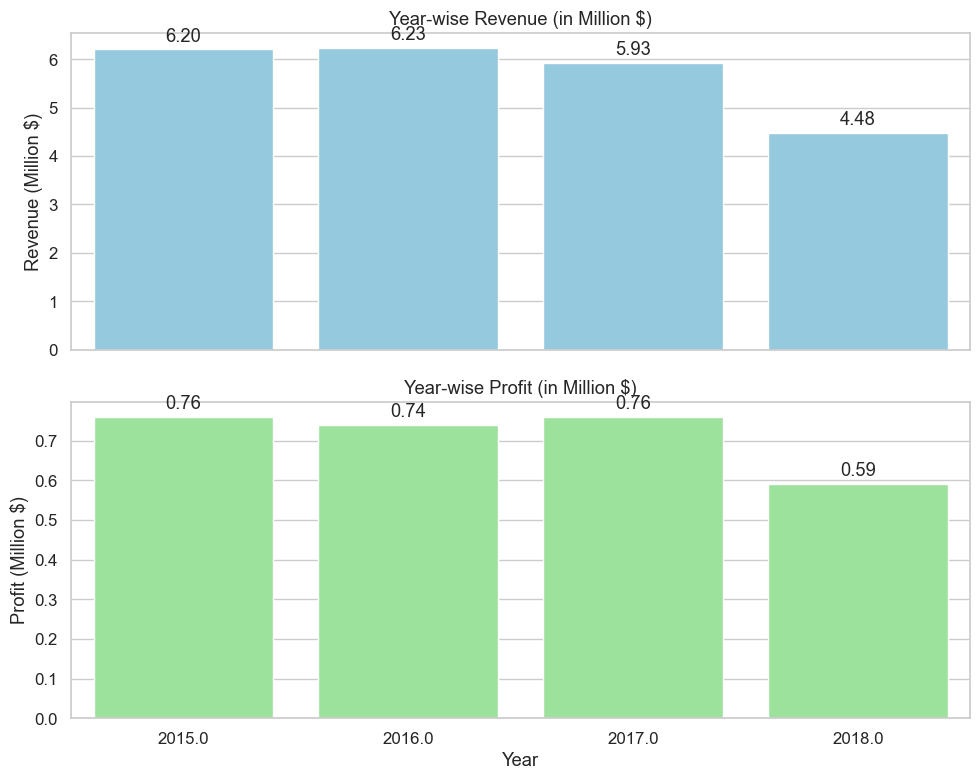

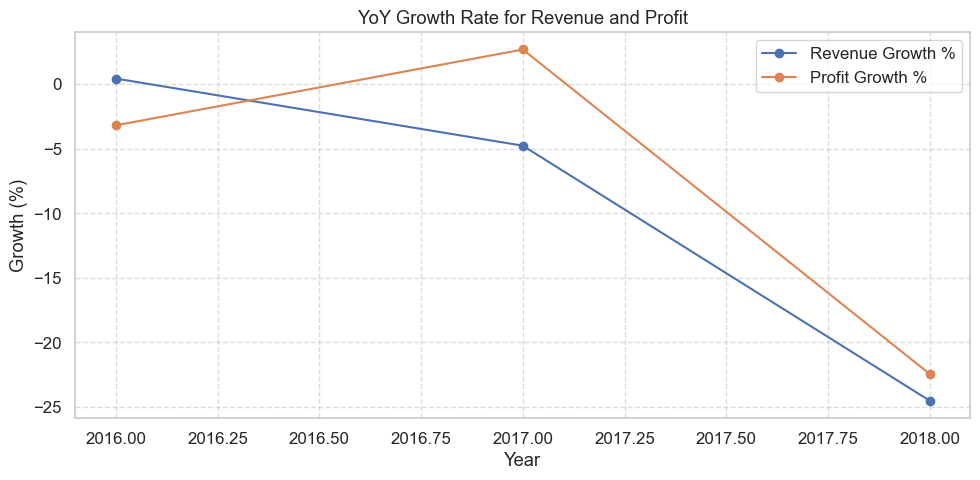

In [55]:
sns.set(style="whitegrid", font_scale=1.1)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Revenue ---
sns.barplot(data=yoy_revenue, x="Year", y="Revenue (M)", color="skyblue", ax=axes[0])
axes[0].set_title("Year-wise Revenue (in Million $)")
axes[0].set_ylabel("Revenue (Million $)")
axes[0].bar_label(axes[0].containers[0], fmt="%.2f", padding=3)

# --- Profit ---
sns.barplot(data=yoy_profit, x="Year", y="Profit (M)", color="lightgreen", ax=axes[1])
axes[1].set_title("Year-wise Profit (in Million $)")
axes[1].set_ylabel("Profit (Million $)")
axes[1].bar_label(axes[1].containers[0], fmt="%.2f", padding=3)

plt.xlabel("Year")
plt.tight_layout()
plt.show()

# --- Separate YoY Growth Line Chart ---
plt.figure(figsize=(10, 5))
plt.plot(
    yoy_revenue["Year"],
    yoy_revenue["YoY_Revenue_Growth (%)"],
    marker="o",
    label="Revenue Growth %",
)
plt.plot(
    yoy_profit["Year"],
    yoy_profit["YoY_Profit_Growth (%)"],
    marker="o",
    label="Profit Growth %",
)
plt.title("YoY Growth Rate for Revenue and Profit")
plt.xlabel("Year")
plt.ylabel("Growth (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Predictive Modeling (XGBoost)
- XGBoost Classifier to predict whether the delivery will be late or not.
- XGBoost Regressor to predict the shipment date incase the delivery is predicted to be late.

In [57]:
data = df[df['Order Status'].isin(completed_statuses)].copy()
data = data[data['Late_delivery_risk'].notna()]

In [58]:
features = [
    'Days for shipment (scheduled)', 'Order Item Quantity',
    'Order Item Discount', 'Order Item Discount Rate',
    'Order Item Product Price', 'Order Item Total',
    'Shipping Mode', 'Order Region', 'Order Country', 'Market',
    'Latitude', 'Longitude'
]

data['order_dt'] = pd.to_datetime(data['order date (DateOrders)'], errors='coerce')
data['order_month'] = data['order_dt'].dt.month
data['order_dayofweek'] = data['order_dt'].dt.dayofweek
features += ['order_month', 'order_dayofweek']

In [59]:
categoricals = ['Shipping Mode', 'Order Region', 'Order Country', 'Market']
le_dict = {}
for col in categoricals:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    le_dict[col] = le

In [60]:
X = data[features].fillna(0)
y = data['Late_delivery_risk'].astype(int)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_cls = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

model_cls.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

=== Classification Report (Late Delivery Risk) ===
              precision    recall  f1-score   support

           0     0.6141    0.8703    0.7201      8640
           1     0.8591    0.5913    0.7005     11562

    accuracy                         0.7106     20202
   macro avg     0.7366    0.7308    0.7103     20202
weighted avg     0.7543    0.7106    0.7089     20202



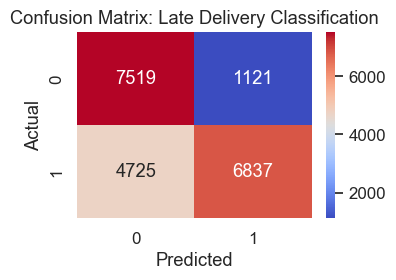

In [62]:
y_pred = model_cls.predict(X_test)

print("=== Classification Report (Late Delivery Risk) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Late Delivery Classification")
plt.tight_layout()
plt.show()

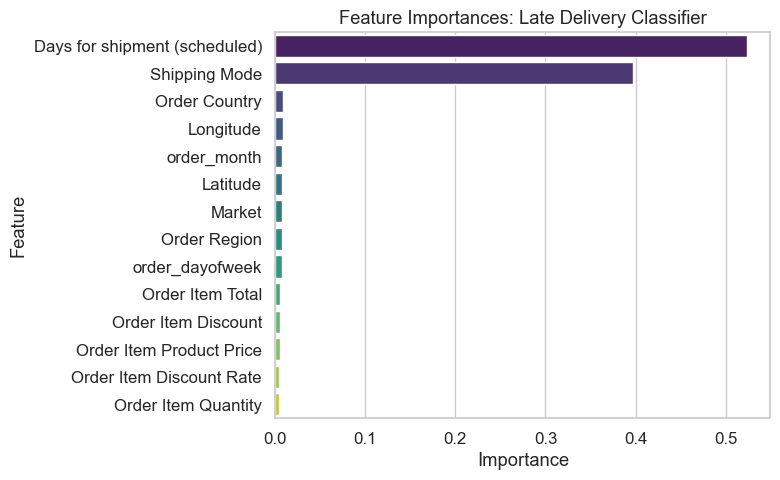

In [63]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_cls.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=importances.head(15), y='Feature', x='Importance', palette='viridis')
plt.title("Feature Importances: Late Delivery Classifier")
plt.tight_layout()
plt.show()

In [64]:
late_only = data[data['Late_delivery_risk'] == 1].copy()

late_only['shipping_delay'] = (
    late_only['Days for shipping (real)'] - late_only['Days for shipment (scheduled)']
)
late_only = late_only[late_only['shipping_delay'].notna()]

In [65]:
X_delay = late_only[features]
y_delay = late_only['shipping_delay']

In [66]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_delay, y_delay, test_size=0.2, random_state=42
)

model_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

In [67]:
model_reg.fit(X_train_d, y_train_d)
y_pred_d = model_reg.predict(X_test_d)

In [70]:
mae = mean_absolute_error(y_test_d, y_pred_d)
rmse = mean_squared_error(y_test_d, y_pred_d, squared=False)
r2 = r2_score(y_test_d, y_pred_d)

print("Delay Regression Model Metrics")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

Delay Regression Model Metrics
MAE:  0.454
RMSE: 0.629
R²:   0.488


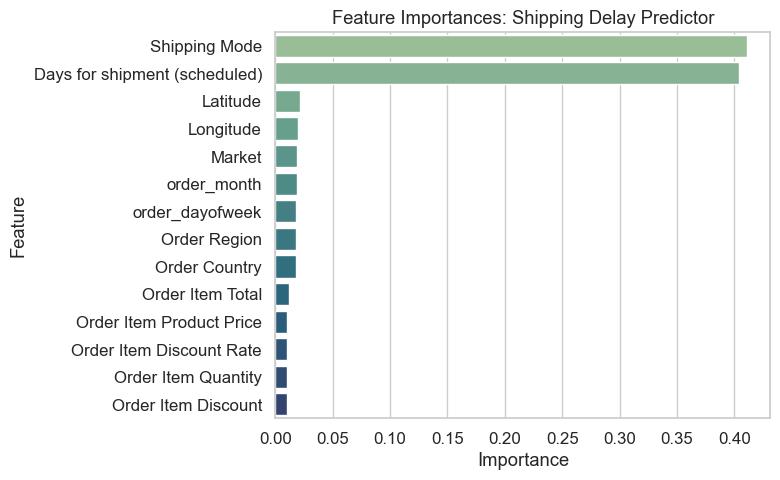

In [71]:
imp_reg = pd.DataFrame({
    'Feature': X_delay.columns,
    'Importance': model_reg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_reg.head(15), y='Feature', x='Importance', palette='crest')
plt.title("Feature Importances: Shipping Delay Predictor")
plt.tight_layout()
plt.show()

## Customer Clustering & Segmentation

In [72]:
order_agg = (
    df.groupby("Order Id")
    .agg(
        CustomerId=("Customer Id", "first"),
        OrderDate=("order_dt", "min"),
        Region=("Order Region", "first"),
        Country=("Order Country", "first"),
        Market=("Market", "first"),
        ShipMode=("Shipping Mode", "first"),
        SchedDays=(
            "Days for shipment (scheduled)",
            "max",
        ),
        RealDays=(
            "Days for shipping (real)",
            "max",
        ),
        LateRisk=("Late_delivery_risk", "max"), 
        Items=("Order Item Id", "nunique"),
        Qty=("Order Item Quantity", "sum"),
        Revenue=("Order Item Total", "sum"),
        Discount=("Order Item Discount", "sum"),
        DiscountRate=("Order Item Discount Rate", "mean"),
        Profit=("Order Profit Per Order", "sum"),
        CatNU=("Category Name", pd.Series.nunique),
        ProdNU=("Product Card Id", pd.Series.nunique),
    )
    .reset_index(drop=False)
)

In [74]:
order_agg["AOV"] = order_agg["Revenue"]  # order-level revenue
order_agg["ProfitMargin"] = np.where(order_agg["Revenue"]>0, order_agg["Profit"]/order_agg["Revenue"], 0)
order_agg["ShippingDelay"] = order_agg["RealDays"] - order_agg["SchedDays"]

In [75]:
ref_date = order_agg["OrderDate"].max()

cust_orders = order_agg.sort_values(["CustomerId", "OrderDate"]).groupby("CustomerId")

customer = cust_orders.agg(
    n_orders=("Order Id", "count"),
    first_order=("OrderDate", "min"),
    last_order=("OrderDate", "max"),
    total_revenue=("Revenue", "sum"),
    total_profit=("Profit", "sum"),
    total_qty=("Qty", "sum"),
    avg_aov=("AOV", "mean"),
    avg_disc_amt=("Discount", "mean"),
    avg_disc_rate=("DiscountRate", "mean"),
    late_rate=("LateRisk", "mean"),
    avg_sched_days=("SchedDays", "mean"),
    avg_real_days=("RealDays", "mean"),
    avg_delay=("ShippingDelay", "mean"),
    mean_items=("Items", "mean"),
    mean_catNU=("CatNU", "mean"),
    mean_prodNU=("ProdNU", "mean"),
    avg_profit_margin=("ProfitMargin", "mean"),
).reset_index()

# Recency (days since last order), Frequency (#orders), Monetary (total revenue)
customer["recency_days"] = (ref_date - customer["last_order"]).dt.days
customer["frequency"] = customer["n_orders"]
customer["monetary"] = customer["total_revenue"]

# Unique categories & countries used (across all items, NOT just order-level means)
# Do from the raw df to get true unique counts per customer
cust_uniques = (
    df.groupby("Customer Id")
    .agg(
        unique_categories=("Category Name", pd.Series.nunique),
        unique_countries=("Order Country", pd.Series.nunique),
    )
    .reset_index()
    .rename(columns={"Customer Id": "CustomerId"})
)

customer = customer.merge(cust_uniques, on="CustomerId", how="left")

# Shipping mode distribution per customer (proportions)
ship_mode_dum = pd.get_dummies(
    order_agg[["CustomerId", "ShipMode"]], columns=["ShipMode"], prefix="mode"
)
ship_mode_by_cust = ship_mode_dum.groupby("CustomerId").sum()
ship_mode_by_cust = ship_mode_by_cust.div(ship_mode_by_cust.sum(axis=1), axis=0).fillna(
    0
)  # proportions
customer = customer.merge(ship_mode_by_cust.reset_index(), on="CustomerId", how="left")

# -------------------------------
# 3) Feature matrix for clustering
# -------------------------------
# Choose well-behaved numeric features (no IDs/dates/strings)
feat_cols = [
    "recency_days",
    "frequency",
    "monetary",
    "avg_aov",
    "total_qty",
    "avg_disc_rate",
    "late_rate",
    "avg_sched_days",
    "avg_delay",
    "mean_items",
    "unique_categories",
    "unique_countries",
    "avg_profit_margin",
] + [c for c in customer.columns if c.startswith("mode_")]

X = customer[feat_cols].copy()

# Replace inf/NaN
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Stabilize skew: log1p for heavy-tailed positive features
for col in [
    "monetary",
    "avg_aov",
    "total_qty",
    "unique_categories",
    "unique_countries",
]:
    X[col] = np.log1p(X[col].clip(lower=0))

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [77]:
best_k, best_score, best_model = None, -1, None
scores = {}

# Find best k using silhouette score
for k in range(3, 9):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    scores[k] = sil

    if sil > best_score:
        best_k, best_score, best_model = k, sil, km

# Print silhouette scores properly
print("Silhouette scores by k:")
for k, score in scores.items():
    print(f"{k} - {round(score, 4)}")

print(f"\nChosen k = {best_k} (silhouette = {best_score:.3f})")

# Assign cluster labels properly
customer = customer.reset_index(drop=True)
customer["cluster"] = best_model.labels_

Silhouette scores by k:
3 - 0.2991
4 - 0.3242
5 - 0.3314
6 - 0.2984
7 - 0.1895
8 - 0.1964

Chosen k = 5 (silhouette = 0.331)


In [78]:
profile_cols = [
    "n_orders",
    "recency_days",
    "frequency",
    "monetary",
    "avg_aov",
    "total_qty",
    "avg_disc_rate",
    "late_rate",
    "avg_sched_days",
    "avg_delay",
    "avg_profit_margin",
    "unique_categories",
    "unique_countries",
] + [c for c in customer.columns if c.startswith("mode_")]

cluster_profile = customer.groupby("cluster")[profile_cols].mean().sort_index()

In [79]:
def unlog_series(s):
    return np.expm1(s)


for col in [
    "monetary",
    "avg_aov",
    "total_qty",
    "unique_categories",
    "unique_countries",
]:
    cluster_profile[col] = unlog_series(cluster_profile[col])

print("\n=== Cluster profile (means) ===")
print(cluster_profile.round(3))

# Size per cluster
print("\n=== Cluster sizes ===")
print(customer["cluster"].value_counts().sort_index())

# Optional: top-level revenue share by cluster
rev_share = (
    customer.groupby("cluster")["total_revenue"].sum()
    / customer["total_revenue"].sum()
    * 100
).round(2)
print("\n=== Revenue share (%) by cluster ===")
print(rev_share)


=== Cluster profile (means) ===
         n_orders  recency_days  frequency       monetary        avg_aov  \
cluster                                                                    
0           4.793       318.631      4.793            inf  5.951489e+240   
1           1.169       109.607      1.169  7.573769e+156  1.904401e+125   
2           1.138        99.118      1.138  2.380471e+145  1.769065e+120   
3           1.033        78.410      1.033  3.322486e+108  1.393685e+105   
4           1.138       112.002      1.138  1.623419e+157  7.651812e+128   

            total_qty  avg_disc_rate  late_rate  avg_sched_days  avg_delay  \
cluster                                                                      
0        4.903168e+13          0.102      0.545           2.967      0.551   
1        1.221900e+01          0.098      0.778           2.016      2.049   
2        7.264000e+00          0.106      0.465           3.270      0.352   
3        2.381000e+00          0.102      0.

c:\Users\conta\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


| Cluster | Segment Name                                   | Behavior Type                        | Risk Level | Value Contribution  |
| ------- | ---------------------------------------------- | ------------------------------------ | ---------- | ------------------- |
| **0**   | **Mass-Market High-Variety Buyers**            | Diverse, frequent, high-order        | Medium     | **Very High (92%)** |
| **1**   | **Delay-Prone Low-Frequency Buyers**           | Low engagement, heavy delays         | High       | Low                 |
| **2**   | **Low-Touch Standard-Class Buyers**            | Low freq, standard shipping          | Low-Medium | Low                 |
| **3**   | **Operationally Smooth Occasional Buyers**     | On-time, budget segment              | Low        | Moderate            |
| **4**   | **Premium-Service Buyers with Extreme Delays** | High-value shipping, failing service | Very High  | Low-Medium          |

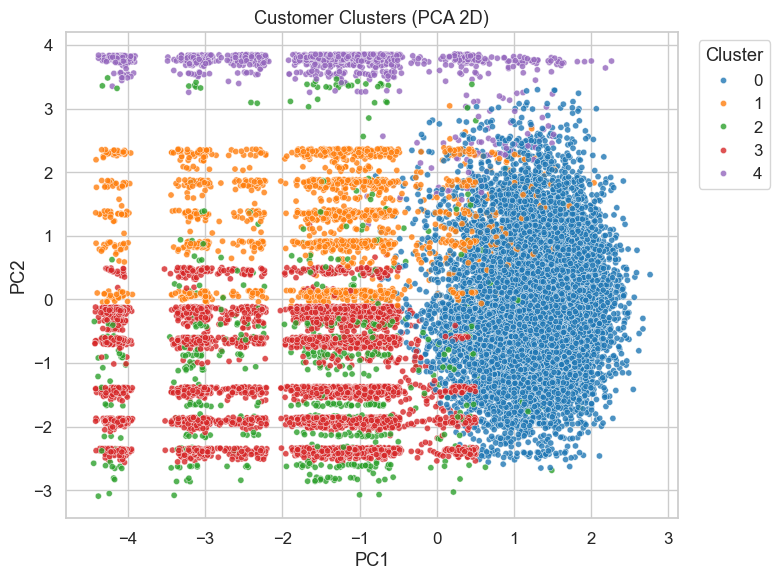

In [80]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster"] = customer["cluster"].values

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2", hue="cluster", palette="tab10", s=20, alpha=0.8
)
plt.title("Customer Clusters (PCA 2D)")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [81]:
out_cols = [
    "CustomerId",
    "cluster",
    "n_orders",
    "recency_days",
    "monetary",
    "avg_aov",
    "late_rate",
    "avg_sched_days",
    "avg_delay",
    "unique_categories",
    "unique_countries",
]
export_df = customer[out_cols].copy()
# Undo logs for readability
for col in ["monetary", "avg_aov"]:
    export_df[col] = np.expm1(export_df[col])
export_df.to_csv("customer_clusters.csv", index=False)
print("\nSaved: customer_clusters.csv")


Saved: customer_clusters.csv


c:\Users\conta\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
